# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [1]:
import numpy as np

def sum_squares(N):
    return (np.arange(N)**2).sum()

In [2]:
%%time
sum_squares(10**8)

CPU times: user 248 ms, sys: 116 ms, total: 364 ms
Wall time: 365 ms


662921401752298880

# theano teaser

Doing the very same thing

In [3]:
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX 765M (CNMeM is disabled, CuDNN 3007)


In [4]:
#I gonna be function parameter
N = T.scalar("a dimension", dtype='int32')

#i am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N)**2).sum()

#Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs = [N],outputs=result)

In [5]:
%%time
sum_function(10**8)

CPU times: user 252 ms, sys: 84 ms, total: 336 ms
Wall time: 336 ms


array(662921401752298880)

# How does it work?
* 1 You define inputs f your future function;
* 2 You write a recipe for some transformation of inputs;
* 3 You compile it;
* You have just got a function!
* The gobbledegooky version: you define a function as symbolic computation graph.


* There are two main kinвs of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * and so on.
   * builtin operations also work that way
   * np.arange(10).mean() -> T.arange(10).mean()
   * Once upon a blue moon the functions have different names or locations (e.g. T.extra_ops)
     * Ask us or google it
 
 
Still confused? We gonna fix that.

In [6]:
#Inputs
example_input_integer = T.scalar("scalar input", dtype='float32')

example_input_tensor = T.tensor4("four dimensional tensor input") #dtype = theano.config.floatX by default
#не бойся, тензор нам не пригодится

input_vector = T.vector("", dtype='int32') # vector of integers

In [7]:
#Transformations

#transofrmation: elementwise multiplication
double_the_vector = input_vector*2

#elementwise cosine
elementwise_cosine = T.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector

In [8]:
#Practice time:
#create two vectors of size float32
my_vector = T.vector("scalar input", dtype='float32')
my_vector2 = T.vector("scalar input", dtype='float32')

In [9]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [10]:
print(my_transformation)
#it's okay it aint a number

Elemwise{true_div,no_inplace}.0


# Compiling
* So far we were using "symbolic" variables and transformations
 * Defining the recipe for computation, but not computing anything
* To use the recipe, one should compile it

In [11]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs,
    outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
)

In [12]:
#using function with, lists:
print("using python lists:")
print(my_function([1,2,3],[4,5,6]))
print()

#Or using numpy arrays:
#btw, that 'float' dtype is casted to secong parameter dtype which is float32
print("using numpy arrays:")
print(my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [13]:
#a dictionary of inputs
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

# evaluate my_transformation
# has to match with compiled function output
print(my_transformation.eval(my_function_inputs))

# can compute transformations on the fly
print("add 2 vectors", (my_vector + my_vector2).eval(my_function_inputs))

#!WARNING! if your transformation only depends on some inputs,
#do not provide the rest of them
print("vector's shape:", my_vector.shape.eval({
        my_vector:[1,2,3]
    }))

[  2.1721766    5.23752832  15.77397728]
add 2 vectors [ 5.  7.  9.]
vector's shape: [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам

In [14]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

v1 = T.vector(dtype='float32')
v2 = T.vector(dtype='float32')

mse = ((v1 - v2)**2).sum() / v1.shape[0]

inputs = [v1, v2]

outputs = [mse]

compute_mse = theano.function(
    inputs,
    outputs,
    allow_input_downcast=True
)

In [15]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n),
             np.arange(n, 0, -1),
             np.zeros(n),
             np.ones(n),
             np.random.random(n),
             np.random.randint(100, size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            
            if not np.allclose(true_mse, my_mse):
                print('Wrong result:')
                print('mse(%s,%s)'%(el, el_2))
                print('should be: {0}, but your function returned {1}'.format(true_mse, my_mse))
                raise ValueError('Что-то не так')

print('All tests passed')

All tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [16]:
#creating shared variable
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [17]:
#evaluating shared variable (outside symbolicd graph)
print('initial value', shared_vector_1.get_value())

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [18]:
#setting new value
shared_vector_1.set_value( np.arange(5) )

#getting that new value
print('new value', shared_vector_1.get_value())

#Note that the vector changed shape
#This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

new value [ 0.  1.  2.  3.  4.]


# Your turn

In [19]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
#Compile as a function of input_scalar

input_scalar = T.scalar('coefficient', dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1

inputs = [input_scalar]
outputs = [scalar_times_shared]

shared_times_n = theano.function(
    inputs,
    outputs,
    allow_input_downcast=True
)

In [20]:
print("shared:", shared_vector_1.get_value())

print("shared_times_n(5)", shared_times_n(5))

print("shared_times_n(-0.5)", shared_times_n(-0.5))

shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [array([  0.,   5.,  10.,  15.,  20.])]
shared_times_n(-0.5) [array([-0. , -0.5, -1. , -1.5, -2. ])]


In [21]:
#Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1,0,1])

print("shared:", shared_vector_1.get_value())

print("shared_times_n(5)",shared_times_n(5))

print("shared_times_n(-0.5)",shared_times_n(-0.5))

shared: [-1.  0.  1.]
shared_times_n(5) [array([-5.,  0.,  5.])]
shared_times_n(-0.5) [array([ 0.5, -0. , -0.5])]


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [22]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

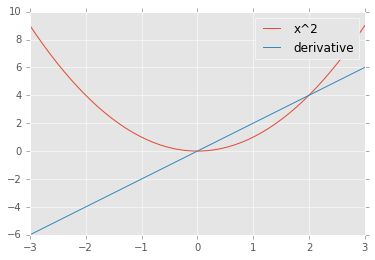

In [23]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

x = np.linspace(-3,3)
x_squared = list(map(fun, x))
x_squared_der = list(map(grad, x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# Why that rocks

In [25]:
my_vector = T.vector('float64')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar, der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)

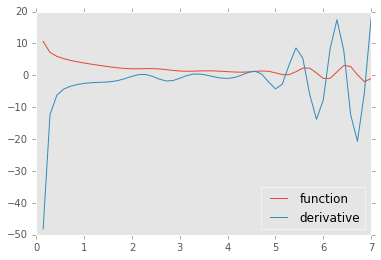

In [26]:
#Plotting your derivative
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar, label='derivative')
plt.grid()
plt.legend(loc='best')

# Almost done - Updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [27]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared] #return vector times scalar

my_updates = {
    shared_vector_1:scalar_times_shared #and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [28]:
shared_vector_1.set_value(np.arange(5))

#initial shared_vector_1
print("initial shared value:" ,shared_vector_1.get_value())

# evaluating the function (shared_vector_1 will be changed)
print("compute_and_save(2) returns",compute_and_save(2))

#evaluate new shared_vector_1
print("new shared value:" ,shared_vector_1.get_value())

initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Logistic regression example

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X,y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [10]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target

print("y [shape - %s]:"%(str(y.shape)), y[:10])
print("X [shape - %s]:"%(str(X.shape)))
print(X[:3])
print(y[:10])

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [14]:
# inputs and shareds
shared_weights = theano.shared(np.ones(X.shape[1], dtype='float64'))
input_X = T.matrix('X', dtype='float64')
input_y = T.vector('y', dtype='float64')

In [19]:
predicted_y = T.nnet.sigmoid(input_X.dot(shared_weights)).T
loss = T.mean(T.log(1 + T.exp(- 4 * (input_y - 0.5) * (input_X.dot(shared_weights) - 0.5))))

grad = T.grad(loss, shared_weights)
learning_rate = 0.1

updates = {
    shared_weights: shared_weights - learning_rate * grad
}

In [22]:
train_function = predict_function = theano.function(
    inputs=[input_X, input_y],
    outputs=loss,
    updates = updates
)

predict_function = theano.function(
    [input_X],
    predicted_y
)

In [17]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

loss at iter 0:318.0741
train auc: 0.992647058824
test auc: 1.0
loss at iter 1:0.8086
train auc: 1.0
test auc: 1.0
loss at iter 2:0.0490
train auc: 1.0
test auc: 1.0
loss at iter 3:0.0275
train auc: 1.0
test auc: 1.0
loss at iter 4:0.0076
train auc: 1.0
test auc: 1.0
resulting weights:


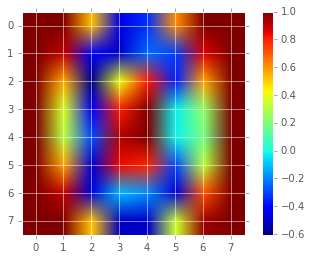

In [23]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print("loss at iter %i:%.4f"%(i, loss_i))
    print("train auc:", roc_auc_score(y_train, predict_function(X_train)))
    print("test auc:", roc_auc_score(y_test, predict_function(X_test)))
    
print("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [5]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [4]:
import lasagne

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [5]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,
                                        input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
dense_1 = lasagne.layers.DenseLayer(input_layer,
                                    num_units=50,
                                    nonlinearity = lasagne.nonlinearities.sigmoid,
                                    name = "hidden_dense_layer")

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1,
                                         num_units = 10,
                                         nonlinearity = lasagne.nonlinearities.softmax,
                                         name='output')

In [6]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [7]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output)
print(all_weights)

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [8]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [9]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [12]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# X - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# y - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

#What do need to implement
# 1) Shuffle data
# - Gotta shuffle X and y the same way not to break the correspondence between X_i and y_i
# 3) Split data into minibatches of batch_size
# - If data size is not a multiple of batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(X, y, batchsize):
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)

        yield X[excerpt], y[excerpt]

# Training loop

In [34]:
import time

num_epochs = 100 #amount of passes through the data

batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 0.765s
  training loss (in-iteration):		1.875889
  train accuracy:		58.73 %
  validation accuracy:		75.75 %
Epoch 2 of 100 took 0.720s
  training loss (in-iteration):		1.202107
  train accuracy:		77.30 %
  validation accuracy:		82.71 %
Epoch 3 of 100 took 0.702s
  training loss (in-iteration):		0.870225
  train accuracy:		82.20 %
  validation accuracy:		85.61 %
Epoch 4 of 100 took 1.099s
  training loss (in-iteration):		0.703184
  train accuracy:		84.52 %
  validation accuracy:		87.24 %
Epoch 5 of 100 took 0.720s
  training loss (in-iteration):		0.605054
  train accuracy:		86.00 %
  validation accuracy:		88.16 %
Epoch 6 of 100 took 1.026s
  training loss (in-iteration):		0.540995
  train accuracy:		87.02 %
  validation accuracy:		88.76 %
Epoch 7 of 100 took 1.033s
  training loss (in-iteration):		0.496139
  train accuracy:		87.71 %
  validation accuracy:		89.12 %
Epoch 8 of 100 took 0.894s
  training loss (in-iteration):		0.463067
  train accuracy:		88.25 %
  valida

In [36]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print("Achievement unlocked: 80lvl Warlock!")
else:
    print("We need more magic!")

Final results:
  test accuracy:		94.91 %
We need more magic!


# A better network


* The quest is to create a network that gets at least 99% at test set
 * In case you tried several architectures and have a __detailed__ report - 97.5% "is fine too". 
 
__ There is a mini-report at the end that you will have to fill in. We recommend to read it first and fill in while you are iterating. __
 

## Tips on what can be done:



 * Network size
   * MOAR neurons, 
   * MOAR layers, 
   * Пх'нглуи мглв'нафх Ктулху Р'льех вгах'нагл фхтагн! 
   
   
   
 * Regularize to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
   * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   
   
   
 * Better optimization - rmsprop, nesterov_momentum, adadelta, adagrad and so on.
   * Converge faster and sometimes reach better optima
   * It might make sense to tweak learning rate, other learning parameters, batch size and number of epochs
   
   
   
 * Dropout - to prevent overfitting
   * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`
   
   
   
 * Convolution layers
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                       num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
 
 * Plenty other layers and architectures
   * http://lasagne.readthedocs.org/en/latest/modules/layers.html
   * batch normalization, pooling, etc
   
   
 * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [4]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape, y_train.shape)

(50000, 1, 28, 28) (50000,)


In [5]:
import lasagne

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

In [93]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape, input_var=input_X)

conv_1 = lasagne.layers.Conv2DLayer(input_layer,
                                    num_filters=24,
                                    filter_size=(5, 5),
                                    nonlinearity=lasagne.nonlinearities.elu)

max_pool1 = lasagne.layers.MaxPool2DLayer(incoming=conv_1,
                                          pool_size=(4, 4),
                                          ignore_border=True
                                         )

dense_1 = lasagne.layers.DenseLayer(max_pool1,
                                    num_units=100,
                                    nonlinearity = lasagne.nonlinearities.elu,
                                    name = "hidden_dense_layer")

dense_output = lasagne.layers.DenseLayer(dense_1,
                                         num_units = 10,
                                         nonlinearity = lasagne.nonlinearities.softmax,
                                         name='output')

In [94]:
# Network predictions (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [95]:
#All weights (shared-varaibles)
# "trainable" flag means not to return auxilary params like batch mean (for batch normalization)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)
print(all_weights)

[W, b, hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


In [96]:
#loss function
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

loss +=  1e-4 * lasagne.regularization.regularize_network_params(dense_output, lasagne.regularization.l2)

#<optionally add regularization>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

#weight updates
updates = lasagne.updates.nesterov_momentum(loss, all_weights, learning_rate=0.01, momentum=0.9)

In [97]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y],
                            [loss,accuracy],
                            updates=updates)

#A function that just computes accuracy given X and y
accuracy_fun = theano.function([input_X, target_y], accuracy)

In [100]:
import time

num_epochs = 150

batch_size = 10

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 150 took 14.624s
  training loss (in-iteration):		0.085202
  train accuracy:		98.18 %
  validation accuracy:		98.31 %
Epoch 2 of 150 took 14.501s
  training loss (in-iteration):		0.063924
  train accuracy:		98.96 %
  validation accuracy:		98.58 %
Epoch 3 of 150 took 14.263s
  training loss (in-iteration):		0.055506
  train accuracy:		99.27 %
  validation accuracy:		98.81 %
Epoch 4 of 150 took 14.329s
  training loss (in-iteration):		0.050217
  train accuracy:		99.41 %
  validation accuracy:		98.80 %
Epoch 5 of 150 took 14.575s
  training loss (in-iteration):		0.047206
  train accuracy:		99.54 %
  validation accuracy:		98.53 %
Epoch 6 of 150 took 14.697s
  training loss (in-iteration):		0.043985
  train accuracy:		99.63 %
  validation accuracy:		98.74 %
Epoch 7 of 150 took 14.683s
  training loss (in-iteration):		0.041583
  train accuracy:		99.68 %
  validation accuracy:		98.89 %
Epoch 8 of 150 took 14.755s
  training loss (in-iteration):		0.039282
  train accuracy:		99.72 %


KeyboardInterrupt: 

In [101]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print("Achievement unlocked: 80lvl Warlock!")
else:
    print("We need more magic!")

Final results:
  test accuracy:		99.03 %
Achievement unlocked: 80lvl Warlock!


Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `Mikhail Usvyatsov`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea (to be honest, several ideas):

First of all I have tried the network with very fat hidden layer(1000 units). It increases the quality of the initial network up to 97%.

Then I tried to add more layers. I have tried the network with 3 hidden layers that had 200, 50 and 200 units. The idea behind this was to make it more generalisable. It was nessesary because on previous network there was a problem of overfitting.

Next I tried to add a dropout. It helped, but the still the result was on the level of 97% after 50 itterations.


Finaly I decided to apply convolutional layer. It really helped. Conv layer + 1 hidden layer + regularization gave me 98 % after 15 itterations. Also I restarted the training with different learning rate.

Then I have found LeNet article and decided to add maxPooling.

Finally I had to tune the size of the batch and it really helped.

That, having wasted 3 hours training, got

* accuracy on training: 99.74
* accuracy on validation: 99.02
* accuracy on test: 99.03

When I faced the validation value greater that 99% I felt likeLeCun and stoped the training. 

We know how NN works given its structure. But we don't know how to build the structure to solve specific problem. I think that the effort should be spent on the methodology of structure definition according to the problem. 